# Exploratory Data Analysis

## Preparations

### Configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyhrv

In [ ]:
!pip install biosppy

### Modules import

In [ ]:
import os
import re
import biosppy
import itertools
import pyhrv

import pandas as pd
import numpy as np

from pyhrv.tools import plot_ecg
from matplotlib import pyplot as plt

from scipy.io import loadmat

### Constants

In [ ]:
class AffectiveStates:
  HVHA = 'HVHA'
  HVLA = 'HVLA'
  LVHA = 'LVHA'
  LVLA = 'LVLA'

  VALENCE_MID = 5
  AROUSAL_MID = 5

class Paths:
  PROJECT_PATH = None # to fill
  VIDEO_LIST = os.path.join(PROJECT_PATH, 'video_list.csv')
  ECG_DATA_PATH = os.path.join(PROJECT_PATH, 'ECGData')

class Labels:
  VALENCE_LABEL = 'AVG_Valence'
  AROUSAL_LABEL = 'AVG_Arousal'

  AFFECTIVE_STATE_LABEL = 'affective_state'
  ARTIST_LABEL = 'Artist'
  TITLE_LABEL = 'Title'
  EXPERIMENT_ID_LABEL = 'Experiment_id'

  ECG_KEY_LABEL = 'ThsECG'
  NUMBER_LABEL = 'number'

  SUBJECT_ID_LABEL = 'subject_id'
  SONG_ID_LABEL = 'song_id'
  SIGNAL_LABEL = 'signal'

  ECG_MAXS_LABEL = 'ecg_maxs'
  ECG_MEANS_LABEL = 'ecg_means'
  ECG_MINS_LABEL = 'ecg_mins'

  HR_MAX_LABEL = 'hr_max'
  HR_MEAN_LABEL = 'hr_mean'
  HR_MIN_LABEL = 'hr_min'

  NNI_MAX_LABEL = 'nni_max'
  NNI_MEAN_LABEL = 'nni_mean'
  NNI_MIN_LABEL = 'nni_min'

  NNI_DIFF_MAX_LABEL = 'nni_diff_max'
  NNI_DIFF_MEAN_LABEL = 'nni_diff_mean'
  NNI_DIFF_MIN_LABEL = 'nni_diff_min'

  SDNN_LABEL = 'sdnn'

class Regexs:
  ECG_CLIP_FILE_REGEX = 'ECG_Clip(?P<number>[0-9]{2}).mat'

class Modes:
  RR_PEAKS_MODE = 'rp'
  SLIDING_WINDOW_MODE = 'sw'
  
  RR_PEAKS_TO_CSV_FORMAT = 'rr_peaks_eda.csv'
  SLIDING_WINDOW_TO_CSV_FORMAT = 'sliding_window_{}_{}_eda.csv'
  
  SLIDING_WINDOW_DEFAULT_PARAMS = (1000, 500)

### Functions


In [ ]:
def get_emotion_from_valence_and_arousal(valence, arousal):
  if valence >= AffectiveStates.VALENCE_MID:
    if arousal >= AffectiveStates.AROUSAL_MID:
      return AffectiveStates.HVHA
    else:
      return AffectiveStates.HVLA
  else:
    if arousal >= AffectiveStates.AROUSAL_MID:
      return AffectiveStates.LVHA
    else:
      return AffectiveStates.LVLA

def get_emotion_labels(va_df):
  return [get_emotion_from_valence_and_arousal(va[0], va[1]) for va in va_df.values]

def load_songs(path):
  raw = pd.read_csv(path)
  raw.rename(columns={Labels.EXPERIMENT_ID_LABEL: Labels.SONG_ID_LABEL}, inplace=True)
  raw.insert(len(raw.columns) - 1, Labels.AFFECTIVE_STATE_LABEL, get_emotion_labels(raw[[Labels.VALENCE_LABEL, Labels.AROUSAL_LABEL]]))
  songs = pd.DataFrame(raw[[Labels.ARTIST_LABEL, Labels.TITLE_LABEL, Labels.AFFECTIVE_STATE_LABEL]])
  songs.index = raw[Labels.SONG_ID_LABEL]

  return songs

def load_signals(path):
  ecg_data = sorted(os.listdir(path))

  data = {
      Labels.SUBJECT_ID_LABEL: [],
      Labels.SONG_ID_LABEL: [],
      Labels.SIGNAL_LABEL: []
  }

  for subject_id in ecg_data:
    subject_dir = os.path.join(path, subject_id)
    subject_data = sorted(os.listdir(subject_dir))
    for ecg_signal in subject_data:
      match = re.search(Regexs.ECG_CLIP_FILE_REGEX, ecg_signal)
      if match:
        data[Labels.SONG_ID_LABEL].append(int(match.group(Labels.NUMBER_LABEL)))
      mat = loadmat(os.path.join(subject_dir, ecg_signal))
      data[Labels.SUBJECT_ID_LABEL].append(int(subject_id[1:]))
      data[Labels.SIGNAL_LABEL].append(mat[Labels.ECG_KEY_LABEL][0])
      print((subject_id, ecg_signal))

  df = pd.DataFrame(data)
  return df

def normalize_signal(signal):
  return (signal - signal.mean()) / signal.max()

def plot_ecg_signal(subject_id, song_id, normalize=False):
  plt.rcParams["figure.figsize"] = [7.50, 3.50]
  plt.rcParams["figure.autolayout"] = True
  signal = df[(df.subject_id == subject_id) & (df.song_id == song_id)]['signal'].to_numpy()[0] * 1000
  
  if normalize:
    signal = normalize_signal(signal)

  plot_ecg(signal, rpeaks=False)

def wrap_rpeaks_with_extremes(left_extreme, rpeaks, right_extreme):
  return np.concatenate(([left_extreme], rpeaks, [right_extreme]))

def pairwise(iterable):
  "s -> (s0,s1), (s1,s2), (s2, s3), ..."
  a, b = itertools.tee(iterable)
  next(b, None)
  return zip(a, b) 

def get_stats_from_ecg_interval(signal, start, end):
  interval = signal[start : end]
  max_ecg = interval.max()
  min_ecg = interval.min()
  mean_ecg = interval.mean()

  return max_ecg, min_ecg, mean_ecg

def get_ecg_features(subject_id, song_id, df, mode=Modes.RR_PEAKS_MODE, sw_params=Modes.SLIDING_WINDOW_DEFAULT_PARAMS):
  signal = df[(df.subject_id == subject_id) & (df.song_id == song_id)][Labels.SIGNAL_LABEL].to_numpy()[0] * 1000

  ecg = biosppy.signals.ecg.ecg(signal, show=False)
  rpeaks = wrap_rpeaks_with_extremes(0, ecg[2], len(signal))
  heart_rate = ecg[6]
  nn_intervals = pyhrv.tools.nn_intervals(rpeaks)
  sdnn = pyhrv.time_domain.sdnn(nn_intervals)[0]
  nni_parameters = pyhrv.time_domain.nni_parameters(nn_intervals)
  nni_max = nni_parameters[3]
  nni_min = nni_parameters[2]
  nni_mean = nni_parameters[1]
  nni_differences_parameters = pyhrv.time_domain.nni_differences_parameters(nn_intervals)
  nni_diff_max = nni_differences_parameters[2]
  nni_diff_min = nni_differences_parameters[1]
  nni_diff_mean = nni_differences_parameters[0]

  features = {
      Labels.ECG_MAXS_LABEL      : [],
      Labels.ECG_MEANS_LABEL     : [],
      Labels.ECG_MINS_LABEL      : [],
      Labels.HR_MAX_LABEL        : heart_rate.max(),
      Labels.HR_MEAN_LABEL       : heart_rate.mean(),
      Labels.HR_MIN_LABEL        : heart_rate.min(),
      Labels.NNI_MAX_LABEL       : nni_max,
      Labels.NNI_MEAN_LABEL      : nni_mean,
      Labels.NNI_MIN_LABEL       : nni_min,
      Labels.NNI_DIFF_MAX_LABEL  : nni_diff_max,
      Labels.NNI_DIFF_MEAN_LABEL : nni_diff_mean,
      Labels.NNI_DIFF_MIN_LABEL  : nni_diff_min,
      Labels.SDNN_LABEL          : sdnn
  }

  if mode == Modes.RR_PEAKS_MODE:
    for start, end in pairwise(rpeaks):
      max_ecg, min_ecg, mean_ecg = get_stats_from_ecg_interval(signal, start, end)
      features[Labels.ECG_MAXS_LABEL].append(max_ecg)
      features[Labels.ECG_MINS_LABEL].append(min_ecg)
      features[Labels.ECG_MEANS_LABEL].append(mean_ecg)
  elif mode == Modes.SLIDING_WINDOW_MODE:
    window_size = sw_params[0]
    stride = sw_params[1]

    for start in range(0, len(signal), stride):
      end = start + window_size
      max_ecg, min_ecg, mean_ecg = get_stats_from_ecg_interval(signal, start, end)
      features[Labels.ECG_MAXS_LABEL].append(max_ecg)
      features[Labels.ECG_MINS_LABEL].append(min_ecg)
      features[Labels.ECG_MEANS_LABEL].append(mean_ecg)

  return features

def generate_experiment_pairs(df):
  patient_ids = df.subject_id.unique()
  song_ids = df.song_id.unique()

  experiment_pairs = []

  for pair in itertools.product(patient_ids, song_ids):
    experiment_pairs.append(pair)

  return experiment_pairs

def assign_stats_from_features(data, features):
  data[Labels.ECG_MAXS_LABEL].append(features[Labels.ECG_MAXS_LABEL])
  data[Labels.ECG_MEANS_LABEL].append(features[Labels.ECG_MEANS_LABEL])
  data[Labels.ECG_MINS_LABEL].append(features[Labels.ECG_MINS_LABEL])
  data[Labels.HR_MAX_LABEL].append(features[Labels.HR_MAX_LABEL])
  data[Labels.HR_MEAN_LABEL].append(features[Labels.HR_MEAN_LABEL])
  data[Labels.HR_MIN_LABEL].append(features[Labels.HR_MIN_LABEL])
  data[Labels.NNI_MAX_LABEL].append(features[Labels.NNI_MAX_LABEL])
  data[Labels.NNI_MEAN_LABEL].append(features[Labels.NNI_MEAN_LABEL])
  data[Labels.NNI_MIN_LABEL].append(features[Labels.NNI_MIN_LABEL])
  data[Labels.NNI_DIFF_MAX_LABEL].append(features[Labels.NNI_DIFF_MAX_LABEL])
  data[Labels.NNI_DIFF_MEAN_LABEL].append(features[Labels.NNI_DIFF_MEAN_LABEL])
  data[Labels.NNI_DIFF_MIN_LABEL].append(features[Labels.NNI_DIFF_MIN_LABEL])
  data[Labels.SDNN_LABEL].append(features[Labels.SDNN_LABEL])

def save_stats_to_csv(source_df, mode=Modes.RR_PEAKS_MODE, sw_params=Modes.SLIDING_WINDOW_DEFAULT_PARAMS):
  data = {
      Labels.SUBJECT_ID_LABEL      : [],
      Labels.SONG_ID_LABEL         : [],
      Labels.ECG_MAXS_LABEL        : [],
      Labels.ECG_MEANS_LABEL       : [],
      Labels.ECG_MINS_LABEL        : [],
      Labels.HR_MAX_LABEL          : [],
      Labels.HR_MEAN_LABEL         : [],
      Labels.HR_MIN_LABEL          : [],
      Labels.NNI_MAX_LABEL         : [],
      Labels.NNI_MEAN_LABEL        : [],
      Labels.NNI_MIN_LABEL         : [],
      Labels.NNI_DIFF_MAX_LABEL    : [],
      Labels.NNI_DIFF_MEAN_LABEL   : [],
      Labels.NNI_DIFF_MIN_LABEL    : [],
      Labels.SDNN_LABEL            : [],
      Labels.AFFECTIVE_STATE_LABEL : []
  }

  experiment_pairs = generate_experiment_pairs(source_df)

  print('Preparing stats...')
  
  for (subject_id, song_id) in experiment_pairs:    
    features = get_ecg_features(subject_id, song_id, source_df, mode=mode, sw_params=sw_params)
    data[Labels.SUBJECT_ID_LABEL].append(subject_id)
    data[Labels.SONG_ID_LABEL].append(song_id)
    data[Labels.AFFECTIVE_STATE_LABEL].append(songs.loc[pd.Index([song_id])][Labels.AFFECTIVE_STATE_LABEL].values[0])
    assign_stats_from_features(data, features)
  
  print('Done!')

  df = pd.DataFrame(data)
  csv_path = Paths.PROJECT_PATH

  if mode == Modes.RR_PEAKS_MODE:
    csv_path = os.path.join(csv_path, Modes.RR_PEAKS_TO_CSV_FORMAT)
  elif mode == Modes.SLIDING_WINDOW_MODE:
    window_size = sw_params[0]
    stride = sw_params[1]
    csv_path = os.path.join(csv_path, Modes.SLIDING_WINDOW_TO_CSV_FORMAT.format(window_size, stride))

  df.to_csv(csv_path, index=False)
  print('File saved!')

## Analysis

### Songs

In [ ]:
songs = load_songs(Paths.VIDEO_LIST)
songs

,Artist,Title,affective_state
song_id,,,
1,EmilĂ­ana Torrini,Jungle Drum,HVHA
2,Lustra,Scotty Doesn't Know,HVHA
3,Jackson 5,Blame It On The Boogie,HVHA
4,The B52'S,Love Shack,HVHA
5,Blur,Song 2,HVHA
6,Blink 182,First Date,HVHA
7,Benny Benassi,Satisfaction,HVHA
8,Lily Allen,Fuck You,HVHA
9,Queen,I Want To Break Free,HVHA


### Signals

In [ ]:
df = load_signals(Paths.ECG_DATA_PATH)
df

('S01', 'ECG_Clip01.mat')
('S01', 'ECG_Clip02.mat')
('S01', 'ECG_Clip03.mat')
('S01', 'ECG_Clip04.mat')
('S01', 'ECG_Clip05.mat')
('S01', 'ECG_Clip06.mat')
('S01', 'ECG_Clip07.mat')
('S01', 'ECG_Clip08.mat')
('S01', 'ECG_Clip09.mat')
('S01', 'ECG_Clip10.mat')
('S01', 'ECG_Clip11.mat')
('S01', 'ECG_Clip12.mat')
('S01', 'ECG_Clip13.mat')
('S01', 'ECG_Clip14.mat')
('S01', 'ECG_Clip15.mat')
('S01', 'ECG_Clip16.mat')
('S01', 'ECG_Clip17.mat')
('S01', 'ECG_Clip18.mat')
('S01', 'ECG_Clip19.mat')
('S01', 'ECG_Clip20.mat')
('S01', 'ECG_Clip21.mat')
('S01', 'ECG_Clip22.mat')
('S01', 'ECG_Clip23.mat')
('S01', 'ECG_Clip24.mat')
('S01', 'ECG_Clip25.mat')
('S01', 'ECG_Clip26.mat')
('S01', 'ECG_Clip27.mat')
('S01', 'ECG_Clip28.mat')
('S01', 'ECG_Clip29.mat')
('S01', 'ECG_Clip30.mat')
('S01', 'ECG_Clip31.mat')
('S01', 'ECG_Clip32.mat')
('S01', 'ECG_Clip33.mat')
('S01', 'ECG_Clip34.mat')
('S01', 'ECG_Clip35.mat')
('S01', 'ECG_Clip36.mat')
('S01', 'ECG_Clip37.mat')
('S01', 'ECG_Clip38.mat')
('S01', 'ECG

,subject_id,song_id,signal
0,1,1,"[0.0005642166159584017, 0.000542686440137885, ..."
1,1,2,"[0.0007301254241859068, 0.0007693862702188026,..."
2,1,3,"[0.0014817003994949118, 0.0015491332590045204,..."
3,1,4,"[0.00030142210552830395, 0.0003014221055283039..."
4,1,5,"[0.0016402587448283157, 0.001731384230652111, ..."
...,...,...,...
1195,30,36,"[0.00047303008294363735, 0.0004723968432074343..."
1196,30,37,"[0.0007434234503023163, 0.0007440566900385193,..."
1197,30,38,"[0.0004787292405694643, 0.00048442839819529127..."
1198,30,39,"[0.0003774108827769851, 0.00037994384172179707..."


### A look on data frame

In [ ]:
df.subject_id.nunique()

30

In [ ]:
df.song_id.nunique()

40

### ECG signal visualizations

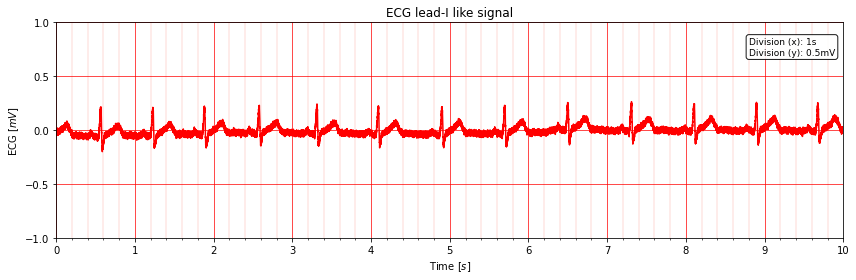

In [ ]:
plot_ecg_signal(1, 3, normalize=True)

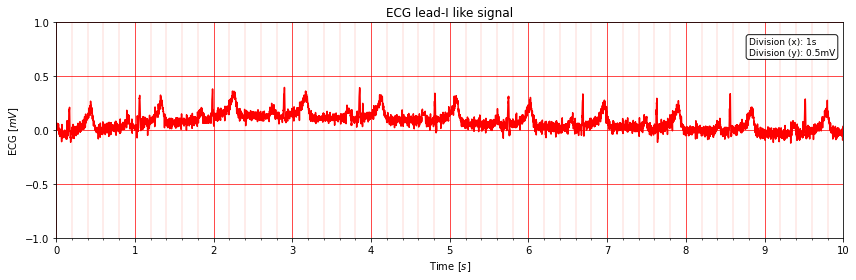

In [ ]:
plot_ecg_signal(20, 15, normalize=True)

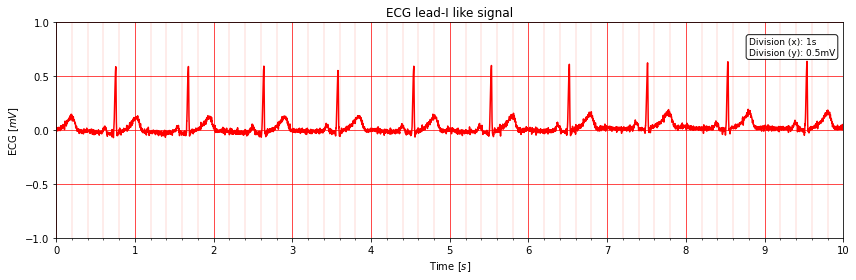

In [ ]:
plot_ecg_signal(14, 22, normalize=True)

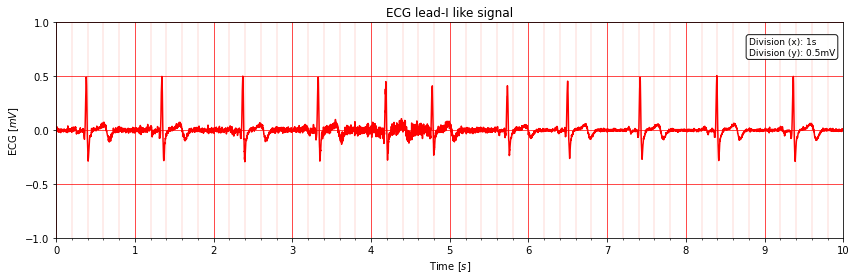

In [ ]:
plot_ecg_signal(29, 37, normalize=True)

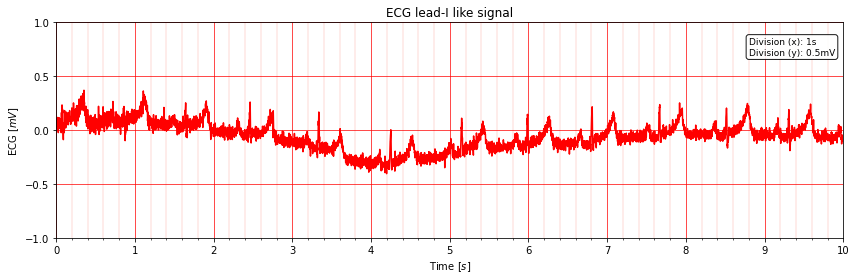

In [ ]:
plot_ecg_signal(20, 27, normalize=True)

### Saving to csv

In [ ]:
save_stats_to_csv(df)

Preparing stats...
Done!
File saved!


In [ ]:
save_stats_to_csv(df, mode=Modes.SLIDING_WINDOW_MODE)

Preparing stats...
Done!
File saved!


In [ ]:
save_stats_to_csv(df, mode=Modes.SLIDING_WINDOW_MODE, sw_params=(2000, 300))

Preparing stats...
Done!
File saved!


In [ ]:
save_stats_to_csv(df, mode=Modes.SLIDING_WINDOW_MODE, sw_params=(2500, 400))

Preparing stats...
Done!
File saved!
